In [1]:
import numpy as np
import pandas as pd
import pickle
import random

from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.preprocessing import StandardScaler, RobustScaler

# Кластеризация
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.neighbors import KNeighborsClassifier

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score as r2

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

matplotlib.rcParams.update({'font.size': 12})

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    
    plt.show()

In [2]:
TRAIN_DATASET_PATH = './DS_Project_csv/train.csv'
TEST_DATASET_PATH = './DS_Project_csv/test.csv'


In [3]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


### Описание датасета
-  **Id** - идентификационный номер квартитры
-  **DistrictId** - идентификационный номер района
-  **Rooms** - количество комнат
-  **Square** - площадь
-  **LifeSquare** - жилая площадь
-  **KitchenSquare** - площадь кухни
-  **Floor** - этаж
-  **HouseFloor** - количество этажей в доме
-  **HouseYear** - год постройки дома
-  **Ecology_1,Ecology_2, Ecology_3** - экологические показатели местности
-  **Social_1, Social_2, Social_3** - социальные показатели местности
-  **HealthCare_1, HealthCare_2** - показатели, связанные с охраной здоровья
-  **Shops_1, Shops_2** - показатели, связанные с наличием торговых точек
-  **Price** - цена квартиры

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [5]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4990,15706,94,2.0,47.776485,27.920873,6.0,8,9.0,1970,0.282798,B,B,33,8667,2,NaN,0,6,B
4991,2105,64,2.0,45.493240,32.022565,6.0,4,9.0,1974,0.135650,B,B,46,7960,6,350.0,3,11,B
4992,7220,96,3.0,80.182493,48.627326,10.0,10,17.0,2003,0.041116,B,B,53,14892,4,NaN,1,4,B
4993,14562,113,2.0,46.627882,27.058739,5.0,6,5.0,1969,0.307467,B,A,30,5048,9,325.0,2,5,B
4994,6836,39,2.0,45.131282,30.780551,6.0,2,5.0,1965,0.428826,B,B,25,5011,8,730.0,0,2,B
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


### Id и DistrictId переводим в строковые данные

In [6]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

## 1.EDA

### **Исследование целевой переменной**

Text(0, 0.5, 'Count')

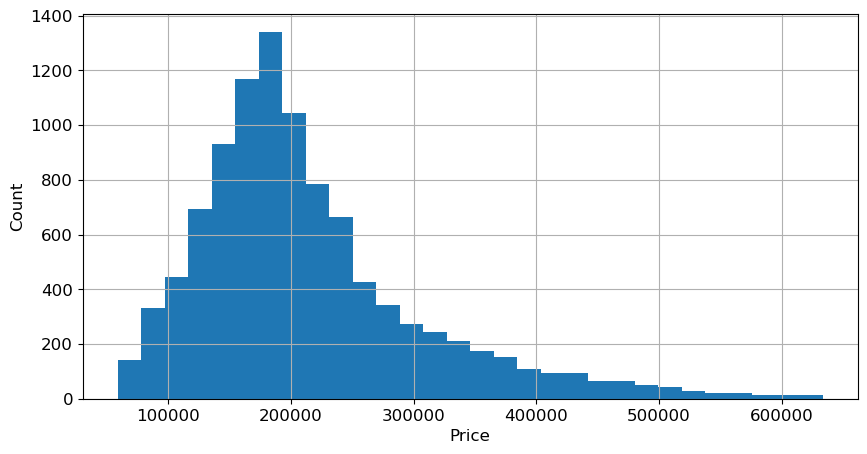

In [8]:
plt.figure(figsize = (10, 5))

train_df['Price'].hist(bins=30)
plt.xlabel('Price')
plt.ylabel('Count')

### **Обзор количественных переменных**

In [9]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### **Обзор категориальных переменных**

In [10]:
train_df.select_dtypes(include='object')

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
0,14038,35,B,B,B
1,15053,41,B,B,B
2,4765,53,B,B,B
3,5809,58,B,B,B
4,10783,99,B,B,B
...,...,...,...,...,...
9995,77,32,B,B,B
9996,6159,18,B,B,A
9997,5123,27,B,B,A
9998,5400,75,B,A,B


In [11]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
174      1
205      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [12]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [13]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [14]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

## **Обработка выбросов**

**1. Rooms**

In [15]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [16]:
train_df['Rooms_ejections'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] > 10), 'Rooms_ejections'] = 1
train_df.loc[train_df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_ejections
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,...,B,11,3097,0,NaN,0,0,B,268394.744389,1
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,...,B,9,1892,0,NaN,0,1,B,302211.260887,1
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,98129.976788,1
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,...,B,30,6207,1,1183.0,1,0,B,217009.338463,1
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,212864.799112,1
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,...,B,2,469,0,NaN,0,0,B,126596.941798,1
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,...,B,43,8429,3,NaN,3,9,B,158998.110646,1
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,219281.918007,1


In [17]:
train_df['Rooms_ejections'].value_counts()

0    9991
1       9
Name: Rooms_ejections, dtype: int64

In [18]:
train_df['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [19]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] > 10, 'Rooms'] = train_df['Rooms'].median()
train_df['Rooms'].value_counts()

2.0     3881
1.0     3713
3.0     2235
4.0      150
5.0       18
10.0       2
6.0        1
Name: Rooms, dtype: int64

**2. KitchenSquare**

In [20]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
32.0         2
41.0         2
51.0         2
30.0         2
112.0        2
37.0         2
43.0         2
25.0         2
58.0         2
84.0         1
75.0         1
21.0         1
54.0         1
62.0         1
40.0         1
29.0         1
1970.0       1
27.0         1
39.0         1
35.0         1
23.0         1
73.0         1
31.0         1
60.0         1
63.0         1
42.0         1
36.0         1
96.0         1
26.0         1
53.0         1
78.0         1
66.0         1
2014.0       1
48.0         1
72.0         1
123.0        1
Name: KitchenSquare, dtype: int64

<AxesSubplot:ylabel='KitchenSquare'>

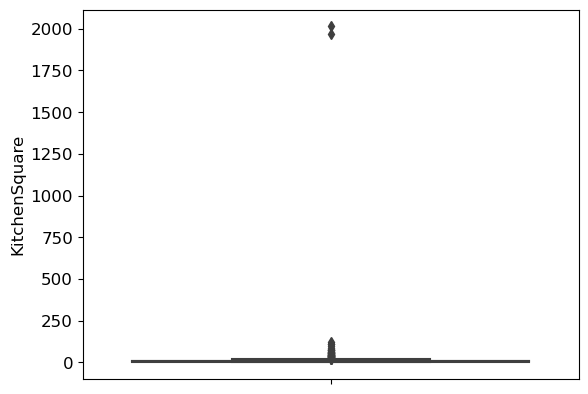

In [21]:
sns.boxplot(y=train_df['KitchenSquare'])

In [22]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [23]:
train_df['KitchenSquare'].quantile(.99), train_df['KitchenSquare'].quantile(.025)

(16.0, 0.0)

In [24]:
train_df['KitchenSquare'].isna().value_counts()

False    10000
Name: KitchenSquare, dtype: int64

In [25]:
train_df.loc[train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.99), 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.322900
std          2.915559
min          3.000000
25%          3.000000
50%          6.000000
75%          9.000000
max         16.000000
Name: KitchenSquare, dtype: float64

In [26]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
5.0     1169
6.0     1129
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
14.0      51
4.0       39
15.0      31
16.0      16
Name: KitchenSquare, dtype: int64

### 3. HouseFloor, Floor.

In [27]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [28]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [29]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [30]:
train_df['HouseFloor_ejections'] = 0
train_df.loc[train_df['HouseFloor'] == 0 | (train_df['Floor'] > train_df['HouseFloor']), 'HouseFloor_ejections'] = 1

In [31]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [32]:
train_df['HouseFloor'].sort_values().unique()

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  36.,
        37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [33]:
floor_ejections = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_ejections

Int64Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1610)

In [34]:
train_df.loc[floor_ejections, 'Floor'] = train_df.loc[floor_ejections, 'HouseFloor'].apply(lambda x: random.randint(1, x))


In [35]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

### 4. HouseYear

In [36]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [37]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
5701        2020
2493        2020
1499        2020
          ...   
7611        1916
910         1914
2656        1912
5111        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int64

In [38]:
train_df['HouseYear'].mode()[0]

1977

In [39]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = train_df['HouseYear'].mode()[0]

In [40]:
train_df['HouseYear'].sort_values(ascending=False)

3859    2020
1499    2020
5701    2020
6735    2020
7076    2020
        ... 
7611    1916
910     1914
2656    1912
5111    1912
9317    1910
Name: HouseYear, Length: 10000, dtype: int64

## Обработка пропусков

In [41]:
train_df.isna().sum()

Id                         0
DistrictId                 0
Rooms                      0
Square                     0
LifeSquare              2113
KitchenSquare              0
Floor                      0
HouseFloor                 0
HouseYear                  0
Ecology_1                  0
Ecology_2                  0
Ecology_3                  0
Social_1                   0
Social_2                   0
Social_3                   0
Healthcare_1            4798
Helthcare_2                0
Shops_1                    0
Shops_2                    0
Price                      0
Rooms_ejections            0
HouseFloor_ejections       0
dtype: int64

### LifeSquare

In [42]:
train_df['LifeSquare_is_NAN'] = train_df['LifeSquare'].isna() * 1

In [43]:
train_df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_ejections,HouseFloor_ejections,LifeSquare_is_NAN
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,NaN,0,11,B,184966.930730,0,0,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,10309,1,240.0,1,16,B,300009.450063,0,0,0
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,7759,0,229.0,1,3,B,220925.908524,0,0,0
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5735,3,1084.0,0,5,B,175616.227217,0,0,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2078.0,2,4,B,150226.531644,0,0,0


In [44]:
condition = (train_df['LifeSquare'].isna() & (~ train_df['Square'].isna()) & (~ train_df['KitchenSquare'].isna()))

In [45]:
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] - train_df.loc[condition, 'KitchenSquare']

In [46]:
train_df.loc[train_df['LifeSquare_is_NAN'] == 1].head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_ejections,HouseFloor_ejections,LifeSquare_is_NAN
7,11993,74,2.0,80.312926,77.312926,3.0,8,13.0,1977,0.075779,...,1437,3,NaN,0,2,B,221244.156664,0,0,1
8,5172,1,2.0,64.511437,61.511437,3.0,9,17.0,1977,0.007122,...,264,0,NaN,0,1,B,229102.795999,0,0,1
21,11935,27,2.0,64.711835,61.711835,3.0,1,1.0,1977,0.211401,...,1892,0,NaN,0,1,B,127200.026511,0,1,1
23,6641,54,3.0,118.907612,115.907612,3.0,2,13.0,1977,0.006076,...,5285,0,645.0,6,6,B,571069.052600,0,0,1
25,5073,74,2.0,82.667915,79.667915,3.0,16,17.0,1977,0.075779,...,1437,3,NaN,0,2,B,244145.827069,0,0,1


In [47]:
train_df.isna().sum()

Id                         0
DistrictId                 0
Rooms                      0
Square                     0
LifeSquare                 0
KitchenSquare              0
Floor                      0
HouseFloor                 0
HouseYear                  0
Ecology_1                  0
Ecology_2                  0
Ecology_3                  0
Social_1                   0
Social_2                   0
Social_3                   0
Healthcare_1            4798
Helthcare_2                0
Shops_1                    0
Shops_2                    0
Price                      0
Rooms_ejections            0
HouseFloor_ejections       0
LifeSquare_is_NAN          0
dtype: int64

### HealthCare_1.

In [48]:
# Т.к. почти у половины объектов отсутствует значение данного признака, то он неинформативен. Его следует удалить.

In [49]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [50]:
train_df.isna().sum()

Id                      0
DistrictId              0
Rooms                   0
Square                  0
LifeSquare              0
KitchenSquare           0
Floor                   0
HouseFloor              0
HouseYear               0
Ecology_1               0
Ecology_2               0
Ecology_3               0
Social_1                0
Social_2                0
Social_3                0
Helthcare_2             0
Shops_1                 0
Shops_2                 0
Price                   0
Rooms_ejections         0
HouseFloor_ejections    0
LifeSquare_is_NAN       0
dtype: int64

### Cоздание общего класса для обработки данных

In [51]:
class DataPreprocessing:
    
    ## Задание параметров класса
    def __init__(self):
        self.medians = None
        self.kitchen_square_quantile = None
        
    ## Сохранение статистик экземпляра класса
    def fit (self, X):
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.99)
        
    ## Обработка признаком экземпляра класса
    def transform (self, X):
        
        ##Rooms
        X['Rooms_ejections'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] > 10), 'Rooms_ejections'] = 1
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > 10, 'Rooms'] = self.medians['Rooms']
        
        ##KitchenSquare
        X.loc[(X['KitchenSquare'].isna()) | (X['KitchenSquare'] > self.kitchen_square_quantile), 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        ##HouseFloor, Floor
        X['HouseFloor_ejections'] = 0
        X.loc[X['HouseFloor'] == 0 | (X['Floor'] > X['HouseFloor']), 'HouseFloor_ejections'] = 1
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        floor_ejections = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_ejections, 'Floor'] = X.loc[floor_ejections, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        
        ##HouseYear
        X['HouseYear_ejections'] = 0
        X.loc[X['HouseYear'] > 2020, 'HouseYear_ejections'] = 1
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = X['HouseYear'].mode()[0]
        
        ##Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        ##LifeSquare
        X['LifeSquare_is_NAN'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna() & (~ X['Square'].isna()) & (~ X['KitchenSquare'].isna()))
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare']
        
        
        X.fillna(self.medians, inplace=True)
        
        return X
        
        
        

## Построение новых признаков

In [52]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    10000 non-null  object 
 1   DistrictId            10000 non-null  object 
 2   Rooms                 10000 non-null  float64
 3   Square                10000 non-null  float64
 4   LifeSquare            10000 non-null  float64
 5   KitchenSquare         10000 non-null  float64
 6   Floor                 10000 non-null  int64  
 7   HouseFloor            10000 non-null  float64
 8   HouseYear             10000 non-null  int64  
 9   Ecology_1             10000 non-null  float64
 10  Ecology_2             10000 non-null  object 
 11  Ecology_3             10000 non-null  object 
 12  Social_1              10000 non-null  int64  
 13  Social_2              10000 non-null  int64  
 14  Social_3              10000 non-null  int64  
 15  Helthcare_2         

### Замена категориальных признаков Ecology_2, Ecology_3, Shops_2

In [53]:
binary_to_numbers = {'A': 0, 'B': 1}
train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)


### Создание новых признаков DistrictSize, IsDistrictLarge

In [54]:
district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns={'index': 'DistrictId','DistrictId': 'DistrictSize'})
district_size.head(5)

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [55]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_ejections,HouseFloor_ejections,LifeSquare_is_NAN,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,0,11,1,184966.930730,0,0,0,22
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,10309,1,1,16,1,300009.450063,0,0,0,87
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,7759,0,1,3,1,220925.908524,0,0,0,174
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5735,3,0,5,1,175616.227217,0,0,0,179
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2,4,1,150226.531644,0,0,0,97


In [56]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [57]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)


### Создание нового признака MedPriceByDistrict

In [58]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'}).rename(columns={'Price': 'MedPriceByDistrict'})
med_price_by_district.head(5)

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [59]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_ejections,HouseFloor_ejections,LifeSquare_is_NAN,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,1,184966.930730,0,0,0,22,0,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,16,1,300009.450063,0,0,0,87,0,300009.450063
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,1,3,1,220925.908524,0,0,0,174,1,263206.223152
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,0,5,1,175616.227217,0,0,0,179,1,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,1,150226.531644,0,0,0,97,0,158539.052715
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,0,6,1,215898.447742,0,0,0,67,0,466753.618497
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,...,1,5,1,296021.204377,0,0,0,10,0,234421.454601
7,11993,74,2.0,80.312926,77.312926,3.0,8,13.0,1977,0.075779,...,0,2,1,221244.156664,0,0,1,114,1,243031.695525
8,5172,1,2.0,64.511437,61.511437,3.0,9,17.0,1977,0.007122,...,0,1,1,229102.795999,0,0,1,652,1,202666.310126
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,...,0,2,1,95380.220993,0,0,0,565,1,102069.270740


### Разбиение этажей и годов постройки домов на бины, создание признака MedPriceByFloorYear

In [60]:
## Создание функций разбиения на бины (добавление их в класс DataPreprocessing)

In [61]:
def floor_to_cut(X):
    bins = [0,3,5,9,15, X['Floor'].max()]
    X['Floor_cut'] = pd.cut(X['Floor'], bins=bins, labels=False)
    X['Floor_cut'].fillna(-1, inplace=True)
    return X

In [62]:
def year_to_cut(X):
    bins = [0,1941,1945,1955, 1965,1980,2000, 2010, X['HouseYear'].max()]
    X['Year_cut'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    X['Year_cut'].fillna(-1, inplace=True)
    return X

In [63]:
floor_bins = [0,3,5,9,15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=floor_bins)

0        (5, 9]
1        (5, 9]
2        (5, 9]
3        (5, 9]
4       (9, 15]
         ...   
9995     (0, 3]
9996    (9, 15]
9997    (9, 15]
9998     (0, 3]
9999     (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64, right]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [64]:
train_df = floor_to_cut(train_df)
train_df = year_to_cut(train_df)
train_df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_ejections,HouseFloor_ejections,LifeSquare_is_NAN,DistrictSize,IsDistrictLarge,MedPriceByDistrict,Floor_cut,Year_cut
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,1,184966.930730,0,0,0,22,0,207786.135836,2,4
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,300009.450063,0,0,0,87,0,300009.450063,2,4
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,1,220925.908524,0,0,0,174,1,263206.223152,2,4
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1,175616.227217,0,0,0,179,1,166809.665642,2,4
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,150226.531644,0,0,0,97,0,158539.052715,3,4


In [65]:
## Создание признака MedPriceByFloorYear

In [66]:
med_price_by_floor_year = train_df.groupby(['Year_cut', 'Floor_cut'], as_index=False).agg({'Price': 'median'}).rename(columns={'Price': 'MedPriceByFloorYear'})
med_price_by_floor_year.head(5)

,Year_cut,Floor_cut,MedPriceByFloorYear
0,0,0,353255.653827
1,0,1,329090.758590
2,0,2,429458.388683
3,0,3,274992.472366
4,1,0,467230.539057


In [67]:
train_df = train_df.merge(med_price_by_floor_year, on=['Year_cut', 'Floor_cut'], how='left')
train_df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_ejections,HouseFloor_ejections,LifeSquare_is_NAN,DistrictSize,IsDistrictLarge,MedPriceByDistrict,Floor_cut,Year_cut,MedPriceByFloorYear
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,184966.930730,0,0,0,22,0,207786.135836,2,4,187916.019862
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,300009.450063,0,0,0,87,0,300009.450063,2,4,187916.019862
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,220925.908524,0,0,0,174,1,263206.223152,2,4,187916.019862
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,175616.227217,0,0,0,179,1,166809.665642,2,4,187916.019862
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,150226.531644,0,0,0,97,0,158539.052715,3,4,183400.653057


### Создание класса FeatureGenerator

In [68]:
class FeatureGenerator():
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, X, y=None):
        X = X.copy()
        
        ## Создание бинарных признаков
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        ##DistrictId
        self.district_size = X['DistrictId'].value_counts().reset_index().rename(columns={'index': 'DistrictId','DistrictId': 'DistrictSize'})
        
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            ## MedPriceByDistrict
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'}).rename(columns={'Price': 'MedPriceByDistrict'})
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
            ## MedPriceByFloorYear
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df = self.floor_to_cut(df)
            df = self.year_to_cut(df)
            self.med_price_by_floor_year = df.groupby(['Year_cut', 'Floor_cut'], as_index=False).agg({'Price': 'median'}).rename(columns={'Price': 'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            
    def transform(self, X):
        ## Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        ##DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X['new-district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new-district'] = 1
        X['DistrictSize'].fillna(5, inplace=True)
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        ## Floor Year cut
        X = self.floor_to_cut(X)
        X = self.year_to_cut(X)
        
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['Year_cut', 'Floor_cut'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
            
        return X
    
    def floor_to_cut(self, X):
        bins = [0,3,5,9,15, self.floor_max]
        X['Floor_cut'] = pd.cut(X['Floor'], bins=bins, labels=False)
        X['Floor_cut'].fillna(-1, inplace=True)
        return X
    
    def year_to_cut(self, X):
        bins = [0,1941,1945,1955, 1965,1980,2000, 2010, self.house_year_max]
        X['Year_cut'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['Year_cut'].fillna(-1, inplace=True)
        return X
    

## Отбор признаков

In [69]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_ejections',
 'HouseFloor_ejections',
 'LifeSquare_is_NAN',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'Floor_cut',
 'Year_cut',
 'MedPriceByFloorYear']

In [70]:
## Разбиение признаков на уже имевшиеся и новые, а также отдельно целевого признака

features_names = ['Rooms','Square','LifeSquare','KitchenSquare','Floor','HouseFloor','HouseYear','Ecology_1','Ecology_2','Ecology_3', 'Social_1','Social_2','Social_3','Helthcare_2','Shops_1','Shops_2']

new_features_names = ['Rooms_ejections','HouseFloor_ejections','LifeSquare_is_NAN','DistrictSize','IsDistrictLarge','MedPriceByDistrict','Floor_cut','Year_cut','MedPriceByFloorYear']

target_name ='Price'

# Разбиение датасета на train, test

In [71]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [72]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [73]:
data_preprocessor = DataPreprocessing()
data_preprocessor.fit(X_train)

X_train = data_preprocessor.transform(X_train)
X_valid = data_preprocessor.transform(X_valid)
test_df = data_preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [74]:
feature_generator = FeatureGenerator()
feature_generator.fit(X_train, y_train)

X_train = feature_generator.transform(X_train)
X_valid = feature_generator.transform(X_valid)
test_df = feature_generator.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 29), (3300, 29), (5000, 29))

In [75]:
X_train = X_train[features_names + new_features_names]
X_valid = X_valid[features_names + new_features_names]
test_df = test_df[features_names + new_features_names]

X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

# Построение модели

In [76]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', random_state=21)

Train R2:	0.967
Test R2:	0.702


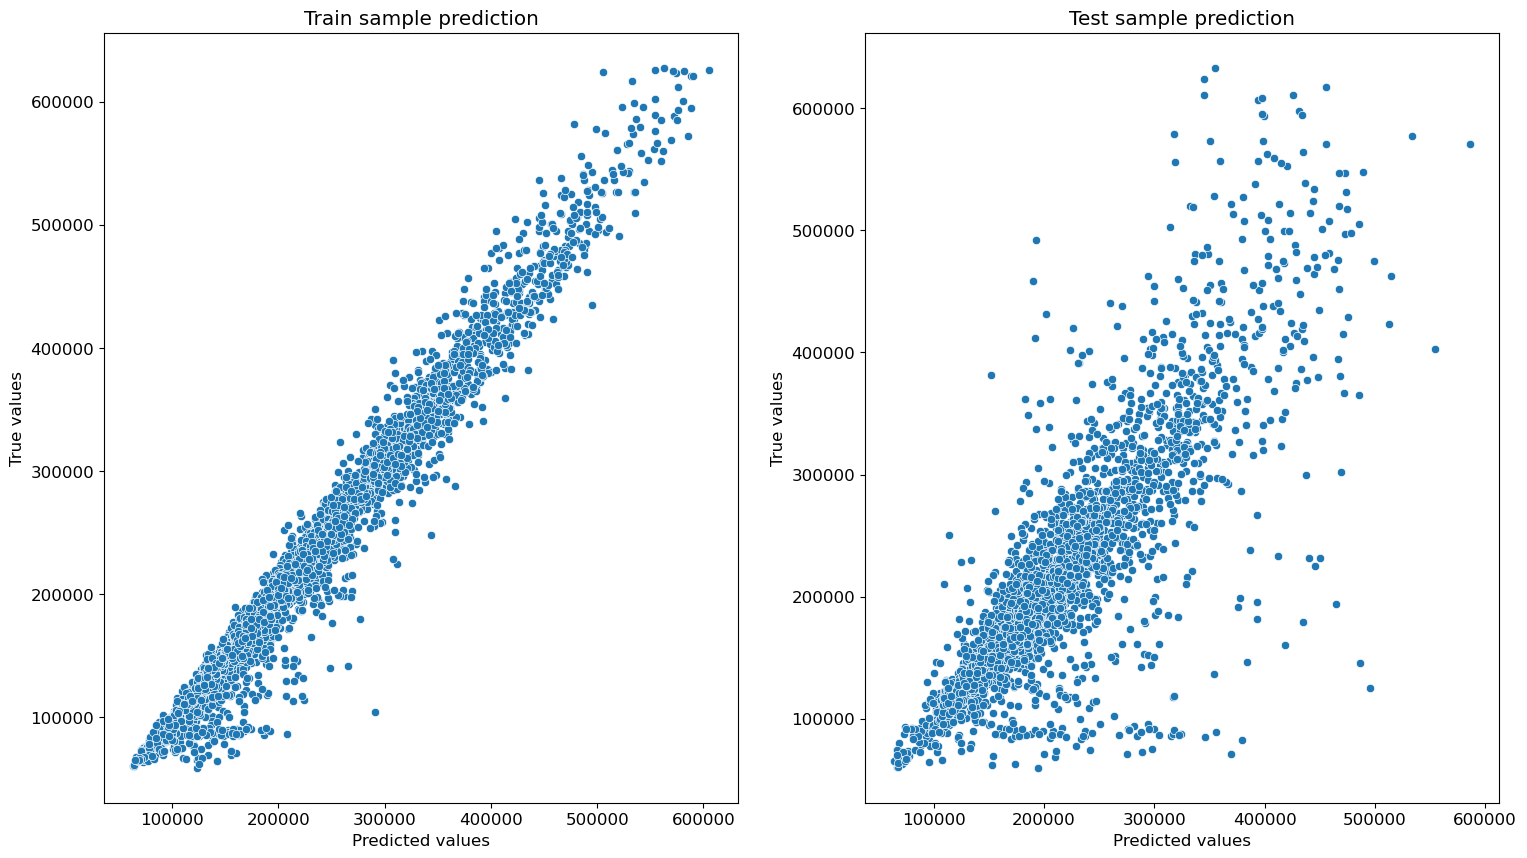

In [77]:
y_train_prediction = rf_model.predict(X_train)
y_valid_prediction = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_prediction, y_valid, y_valid_prediction)

In [78]:
## Применение кросс-валидации для исключения переобучения модели

In [79]:
cross_val = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))

In [80]:
cross_val

array([0.75901357, 0.75055196, 0.76135506])

In [81]:
cross_val.mean()

0.7569735285164646

In [82]:
## Определим важность признаков

In [83]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), columns=['feature_name', 'importance'])

In [84]:
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
21,MedPriceByDistrict,0.637482
1,Square,0.114027
2,LifeSquare,0.031579
12,Social_3,0.023007
3,KitchenSquare,0.022567
24,MedPriceByFloorYear,0.022094
19,DistrictSize,0.021925
6,HouseYear,0.019644
5,HouseFloor,0.019067
7,Ecology_1,0.015759


In [85]:
## Вывод: наиболее важные признаки для модели - MedPriceByDistrict, Square.

# Работа подобранной модели на тестовой выборке

In [86]:
test_df.shape

(5000, 25)

In [88]:
predictions = rf_model.predict(test_df)
predictions

array([162950.90580003, 230597.86315888, 272541.06393542, ...,
       347349.95781514, 183041.48177569, 185459.26674353])